In [71]:

import numpy as np
import pandas as pd
from datetime import datetime
from fuzzywuzzy import process, fuzz
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [72]:
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\DSTI\Python Machine Learning Labs\Project-20221212\books_v2.csv", index_col = "bookID")

# Feature Engineering 

## Data Cleaning 

In [79]:
#Renaming '  num_pages' in order to remove the extra spaces and displaying columns names
df.rename(columns={'  num_pages':'num_pages'}, inplace=True)


In [80]:
#Dropping useless columns: isbn and isbn13
df = df.drop(columns = ['isbn','isbn13'])

In [81]:
#For the language_code column, replacing the value eng-US, en-CA and eng-GB with the value eng
df.language_code = df.language_code.replace({'en-US':'eng', 'en-GB':'eng', 'en-CA':'eng'})

Keeping top 4 languages & dropping others 

### Date Column

THOSE 2 DATES ARE UNREAL IN THE SENSE THAT
    # NOVEMBER DOESN'T HAVE 31 DAYS (11/31/2000)
    # JUNE DOESN'T HAVE 31 DAYS (31/06/1982)

=> REPLACE BY CORRECT DATE FOR THOSE 2 ROWS

    #31373 PUBLISHED OCTOBER 31, 2000 BY BANTAM BOOKS (HTTPS://WWW.GOODREADS.COM/BOOK/SHOW/31373.IN_PURSUIT_OF_THE_PROPER_SINNER?AC=1&FROM_SEARCH=TRUE&QID=3A5ZOTZGSY&RANK=1)

    #45531 PUBLISHED JUNE 30, 1982 BY FOLIO HISTOIRE (HTTPS://WWW.GOODREADS.COM/BOOK/SHOW/45531.MONTAILLOU_VILLAGE_OCCITAN_DE_1294_1324)

In [82]:
#correcting 2 NaT by correct date
df.loc[31373,"publication_date"]='10/30/2000'
df.loc[45531,"publication_date"] ='6/30/1982'
df.loc[[31373,45531]]


,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher
bookID,,,,,,,,,,,,
31373,NaN,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,eng,718,10608,295,10/30/2000,NaN,NaN,Bantam Books
45531,NaN,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,fre,640,15,2,6/30/1982,NaN,NaN,Folio histoire


In [83]:
# Changing the publication_date colummn type to a date format 
df['publication_date'] = pd.to_datetime(df['publication_date'], dayfirst = False, yearfirst = False, errors = 'coerce')


In [84]:
# Splitting date column into month and year columns 
df['month'] = df['publication_date'].dt.month
df['year'] = df['publication_date'].dt.year

<AxesSubplot:xlabel='year', ylabel='average_rating'>

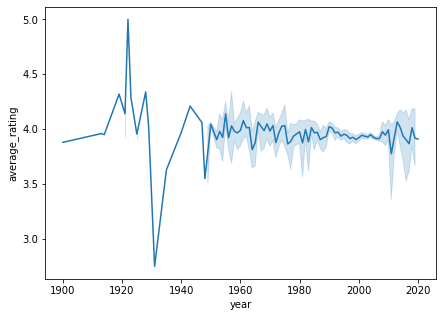

In [85]:
# Average rating over the years
fig = plt.gcf()
fig.set_size_inches(7, 5)
sns.lineplot(x="year", y="average_rating", data=df)

<AxesSubplot:xlabel='month', ylabel='average_rating'>

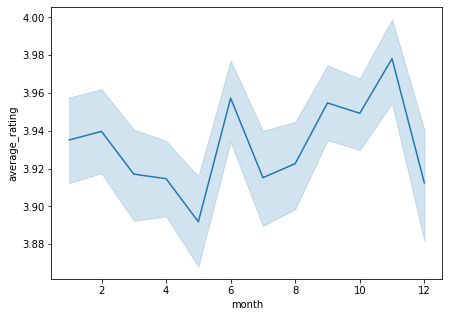

In [86]:
#average rating evolution over the months 
fig = plt.gcf()
fig.set_size_inches(7, 5)
sns.lineplot(x="month", y="average_rating", data=df)
# better rating around end of the year 

## Rating counts = 0 & Avg Rating = 0

In [87]:
# Dropping the rows where the  average rating of a book is set to 0 AND rating counts set to 0
len(df.loc[(df['average_rating'] == 0) & (df['ratings_count'] == 0)])


26

In [88]:
idx_to_drop = df.loc[(df['average_rating'] == 0) & (df['ratings_count'] == 0)].index
df.drop(idx_to_drop, inplace=True)

## Author Column

In [89]:
# single author vs multiple authors -> new column "Authors_2" = Single/Multiple -> boolean
df['number_of_authors']=np.where(df['authors'].str.split(pat="/").str.len()==1, "single", "multiple")

#keep 1st author in case of multiple authors and analyze correlation
df['primary_author']=df['authors'].str.split(pat="/").str[0]

df.head(3)

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher,number_of_authors,primary_author
bookID,,,,,,,,,,,,,,
1,NaN,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,2006-09-16,9,2006,Scholastic Inc.,multiple,J.K. Rowling
2,NaN,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,2004-09-01,9,2004,Scholastic Inc.,multiple,J.K. Rowling
4,NaN,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,2003-11-01,11,2003,Scholastic,single,J.K. Rowling


In [90]:
#author_page=df.groupby('primary_author')['num_pages'].mean()
#frames=[author_page, authors]
#pd.concat(frames,axis=1).sort_values('count', ascending = False)

## Audio Books

In [91]:
audio_df=df[df.num_pages>24]
audio_df.sort_values(by = ['num_pages']).head(10)

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher,number_of_authors,primary_author
bookID,,,,,,,,,,,,,,
2386,NaN,Moby Dick,Herman Melville/William Hootkins,3.50,eng,25,67,17,2005-09-01,9,2005,Naxos Audiobooks,multiple,Herman Melville
9072,NaN,The Historian,Elizabeth Kostova/Paul Michael/Justine Eyre,3.78,eng,26,354,135,2005-12-13,12,2005,Books on Tape,multiple,Elizabeth Kostova
45325,NaN,Joseph Cornell: Secrets in a Box (Adventures i...,Alison Baverstock/Joseph Cornell/Christopher W...,4.03,eng,27,32,5,2003-09-01,9,2003,Prestel Publishing,multiple,Alison Baverstock
7615,NaN,Farm Animals (A Chunky Book),Phoebe Dunn,3.86,eng,28,35,4,1984-02-12,2,1984,Random House Books for Young Readers,single,Phoebe Dunn
17296,NaN,Music of the Meadow (Little Einsteins Early Re...,Susan Ring/Kelly Preston/Katie Nix,3.70,eng,28,26,1,2006-09-01,9,2006,Disney Press,multiple,Susan Ring
3051,NaN,Sir Gawain and the Green Knight,Selina Shirley Hastings/Juan Wijngaard,3.91,eng,29,65,9,1991-06-27,6,1991,Walker Books Ltd,multiple,Selina Shirley Hastings
44849,NaN,Code Check Electrical: An Illustrated Guide to...,Michael Casey/Redwood Kardon/Douglas Hansen,4.67,eng,29,3,0,2005-11-11,11,2005,Taunton Press,multiple,Michael Casey
26216,NaN,Patrick: Patron Saint of Ireland,Tomie dePaola,4.08,eng,30,89,5,1992-01-01,1,1992,Holiday House,single,Tomie dePaola
6466,NaN,George Washington's Rules of Civility & Decent...,George Washington,4.08,eng,30,835,113,1989-08-01,8,1989,Applewood Books,single,George Washington


In [92]:
# look at different publisher name to see if audio book or not
keep= ["fono"]

#filter for rows that contain the partial string "Wes" in the conference column
df[df.publisher.str.contains('|'.join(keep))].sort_values(by = ['num_pages'])

# "Tantor Media"-containing publisher name = AUDIO (note: pages <= 6)
# "Caedmon"-containing publisher name = AUDIO (note: pages <= 11)
# "HarperFestival"-containing publisher name = AUDIO (note: 1 "book" counts 31 pages but it's 31 CDs)
# "Pimsleur"-containing publisher name = AUDIO (note: only 1 book)
# "FonoLibro"-containing publisher name = AUDIO (note: only 1 book - 18 pages
# "Disney Press", Warne" AND "TSR Inc" publish short book for kids
# "Studio"-containing publisher name = only paper book - to keep

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher,number_of_authors,primary_author
bookID,,,,,,,,,,,,,,


Create new column "Type" with 2 categories: AUDIBLE or READABLE

* Select title with CD
* Apply on publisher based on the list ["Audio", "Record", "Sound", "Tape", "Tantor", "Warner Adult", "HarperFestival","Pimsleur", "FonoLibro"]
* Apply on num_pages <=15 (assumption that all books with less (or equal) than 15 pages are Audio)

In [93]:
keep= ["Audio", "Record", "Sound", "Tape", "Tantor", "Warner Adult", "HarperFestival","Pimsleur", "FonoLibro"]
conditions = [df.authors == 'NOT A BOOK', df.title.str.contains('|'.join(["CD"])), df.publisher.str.contains('|'.join(keep)), df.num_pages <= 15]
choices =['audible','audible', 'audible','audible']                                                                                  
df['type'] = np.select(conditions, choices, default="readable")                                                                             
                                                                                  
#df[df.authors == 'NOT A BOOK']
df.head(15)

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher,number_of_authors,primary_author,type
bookID,,,,,,,,,,,,,,,
1,NaN,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,2006-09-16,9,2006,Scholastic Inc.,multiple,J.K. Rowling,readable
2,NaN,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,2004-09-01,9,2004,Scholastic Inc.,multiple,J.K. Rowling,readable
4,NaN,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,2003-11-01,11,2003,Scholastic,single,J.K. Rowling,readable
5,NaN,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,2004-05-01,5,2004,Scholastic Inc.,multiple,J.K. Rowling,readable
8,NaN,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,eng,2690,41428,164,2004-09-13,9,2004,Scholastic,multiple,J.K. Rowling,readable
9,NaN,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,eng,152,19,1,2005-04-26,4,2005,Nimble Books,single,W. Frederick Zimmerman,readable
10,NaN,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,eng,3342,28242,808,2005-09-12,9,2005,Scholastic,single,J.K. Rowling,readable
12,NaN,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,eng,815,3628,254,2005-11-01,11,2005,Gramercy Books,single,Douglas Adams,readable
13,NaN,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,eng,815,249558,4080,2002-04-30,4,2002,Del Rey Books,single,Douglas Adams,readable


In [94]:
df.groupby(["type"]).describe().average_rating
#imbalanced 

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
audible,295.0,3.997661,0.350928,1.0,3.83,4.01,4.20,5.0
readable,10806.0,3.941347,0.295215,1.0,3.77,3.96,4.13,5.0


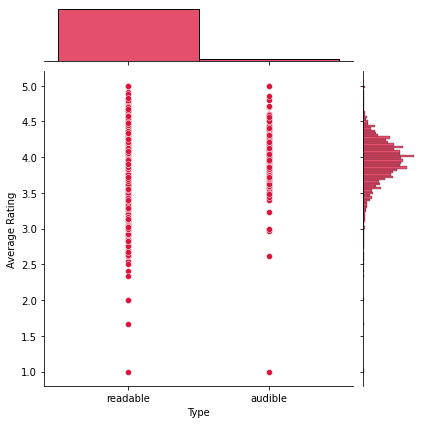

In [95]:
ax3 = sns.jointplot(y="average_rating", x="type", data = df, color = 'crimson')
ax3.set_axis_labels("Type", "Average Rating")


In [96]:
audible = df.loc[df.type == "audible"]

In [97]:
audible

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher,number_of_authors,primary_author,type
bookID,,,,,,,,,,,,,,,
16,NaN,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams/Stephen Fry,4.22,eng,6,1266,253,2005-03-23,3,2005,Random House Audio,multiple,Douglas Adams,audible
68,NaN,The Known World,Edward P. Jones/Kevin R. Free,3.83,eng,14,55,12,2004-06-15,6,2004,HarperAudio,multiple,Edward P. Jones,audible
524,NaN,Lord of the Flies,William Golding,3.68,eng,6,408,96,2005-10-11,10,2005,Listening Library (Audio),single,William Golding,audible
955,NaN,The 5 Love Languages / The 5 Love Languages Jo...,Gary Chapman,4.70,eng,0,22,4,2005-01-01,1,2005,Moody Publishers,single,Gary Chapman,audible
966,NaN,Angeles & Demonios,Dan Brown/Raúl Amundaray,3.89,spa,18,65,7,2005-12-01,12,2005,FonoLibro,multiple,Dan Brown,audible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45465,NaN,Artemis Fowl (Artemis Fowl #1),Eoin Colfer/Nathaniel Parker,3.84,eng,6,55,14,2004-04-06,4,2004,Listening Library,multiple,Eoin Colfer,audible
45472,NaN,Treasury of American Tall Tales: Volume 1: Dav...,David Bromberg/Jay Ungar/Molly Mason/Garrison ...,3.86,eng,0,36,9,2006-08-22,8,2006,Listening Library (Audio),multiple,David Bromberg,audible
45485,NaN,The Subtle Knife (His Dark Materials #2),Philip Pullman,4.13,eng,8,39,8,2000-01-28,1,2000,Listening Library,single,Philip Pullman,audible


## Handling Outliers

### Pages column

In [98]:
percentile25 = df['num_pages'].quantile(0.25)
percentile75 = df['num_pages'].quantile(0.75)
iqr = percentile75 - percentile25
print ("IQR: ",iqr)
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
df = df[df['num_pages']< upper_limit]
df

IQR:  223.0


,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher,number_of_authors,primary_author,type
bookID,,,,,,,,,,,,,,,
1,NaN,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,2006-09-16,9,2006,Scholastic Inc.,multiple,J.K. Rowling,readable
4,NaN,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,2003-11-01,11,2003,Scholastic,single,J.K. Rowling,readable
5,NaN,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,2004-05-01,5,2004,Scholastic Inc.,multiple,J.K. Rowling,readable
9,NaN,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,eng,152,19,1,2005-04-26,4,2005,Nimble Books,single,W. Frederick Zimmerman,readable
14,NaN,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,eng,215,4930,460,2004-08-03,8,2004,Crown,single,Douglas Adams,readable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45631,NaN,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,eng,512,156,20,2004-12-21,12,2004,Da Capo Press,multiple,William T. Vollmann,readable
45633,NaN,You Bright and Risen Angels,William T. Vollmann,4.08,eng,635,783,56,1988-12-01,12,1988,Penguin Books,single,William T. Vollmann,readable
45634,NaN,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,eng,415,820,95,1993-08-01,8,1993,Penguin Books,single,William T. Vollmann,readable


In [99]:
lower_limit

-141.5

### Rating_count

In [100]:
percentile25_rating = df['ratings_count'].quantile(0.25)
percentile75_rating = df['ratings_count'].quantile(0.75)
iqr2 = percentile75_rating - percentile25_rating
print ("IQR: ",iqr2)
upper_limit_rating = percentile75_rating + 1.5 * iqr2
lower_limit_rating = percentile25_rating - 1.5 * iqr2
df = df[df['ratings_count']< upper_limit_rating]
df

IQR:  4868.5


,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher,number_of_authors,primary_author,type
bookID,,,,,,,,,,,,,,,
4,NaN,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,2003-11-01,11,2003,Scholastic,single,J.K. Rowling,readable
9,NaN,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,eng,152,19,1,2005-04-26,4,2005,Nimble Books,single,W. Frederick Zimmerman,readable
14,NaN,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,eng,215,4930,460,2004-08-03,8,2004,Crown,single,Douglas Adams,readable
16,NaN,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams/Stephen Fry,4.22,eng,6,1266,253,2005-03-23,3,2005,Random House Audio,multiple,Douglas Adams,audible
22,NaN,Bill Bryson's African Diary,Bill Bryson,3.44,eng,55,7270,499,2002-12-03,12,2002,Broadway Books,single,Bill Bryson,readable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45631,NaN,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,eng,512,156,20,2004-12-21,12,2004,Da Capo Press,multiple,William T. Vollmann,readable
45633,NaN,You Bright and Risen Angels,William T. Vollmann,4.08,eng,635,783,56,1988-12-01,12,1988,Penguin Books,single,William T. Vollmann,readable
45634,NaN,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,eng,415,820,95,1993-08-01,8,1993,Penguin Books,single,William T. Vollmann,readable


### Text_Reviews_Count

In [101]:
percentile25_text = df['text_reviews_count'].quantile(0.25)
percentile75_text = df['text_reviews_count'].quantile(0.75)
iqr3 = percentile75_text - percentile25_text
print ("IQR: ",iqr3)
upper_limit_text = percentile75_text + 1.5 * iqr3
lower_limit_text = percentile25_text - 1.5 * iqr3
df = df[df['text_reviews_count']< upper_limit_text]
df

IQR:  101.0


,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher,number_of_authors,primary_author,type
bookID,,,,,,,,,,,,,,,
4,NaN,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,2003-11-01,11,2003,Scholastic,single,J.K. Rowling,readable
9,NaN,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,eng,152,19,1,2005-04-26,4,2005,Nimble Books,single,W. Frederick Zimmerman,readable
16,NaN,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams/Stephen Fry,4.22,eng,6,1266,253,2005-03-23,3,2005,Random House Audio,multiple,Douglas Adams,audible
23,NaN,Bryson's Dictionary of Troublesome Words: A Wr...,Bill Bryson,3.87,eng,256,2088,131,2004-09-14,9,2004,Broadway Books,single,Bill Bryson,readable
37,NaN,The Lord of the Rings: Complete Visual Companion,Jude Fisher,4.50,eng,224,359,6,2004-11-15,11,2004,Houghton Mifflin Harcourt,single,Jude Fisher,readable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45631,NaN,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,eng,512,156,20,2004-12-21,12,2004,Da Capo Press,multiple,William T. Vollmann,readable
45633,NaN,You Bright and Risen Angels,William T. Vollmann,4.08,eng,635,783,56,1988-12-01,12,1988,Penguin Books,single,William T. Vollmann,readable
45634,NaN,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,eng,415,820,95,1993-08-01,8,1993,Penguin Books,single,William T. Vollmann,readable


In [102]:
#old df = 11127 rows
#new df = 7955 rows
# diff : -

In [114]:
df = df.reindex(columns=['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'month', 'year','publisher'])

## Correlation

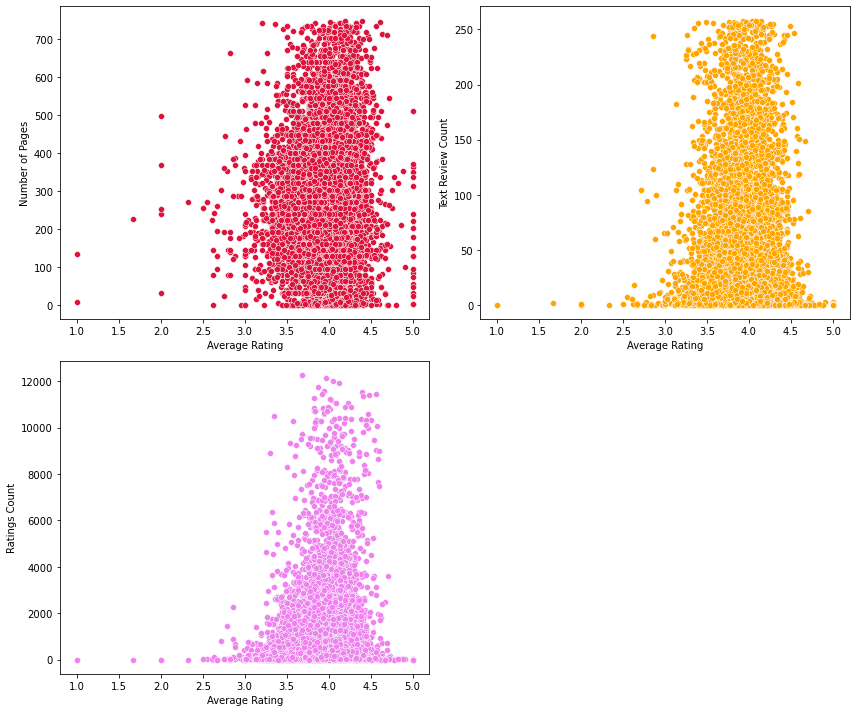

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Average Rating vs Number of Pages
sns.scatterplot(x="average_rating", y="num_pages", data=df, ax=axes[0, 0], color='crimson')
axes[0, 0].set_xlabel("Average Rating")
axes[0, 0].set_ylabel("Number of Pages")

# Average Rating vs Text Review Count
sns.scatterplot(x="average_rating", y="text_reviews_count", data=df, ax=axes[0, 1], color='orange')
axes[0, 1].set_xlabel("Average Rating")
axes[0, 1].set_ylabel("Text Review Count")

# Average Rating vs Ratings Count
sns.scatterplot(x="average_rating", y="ratings_count", data=df, ax=axes[1, 0], color='violet')
axes[1, 0].set_xlabel("Average Rating")
axes[1, 0].set_ylabel("Ratings Count")

# remove empty subplot
fig.delaxes(axes[1, 1])

fig.tight_layout()

# show the plot
plt.show()


## Categorization avg rating 

In [104]:
# 5.001 to include the rating = 5
bins = [ 0,3,4, 5.001]
label = ['Low',"Mid","High"]
df['cat_rating'] = pd.cut(df['average_rating'], bins, labels=label, right = False)

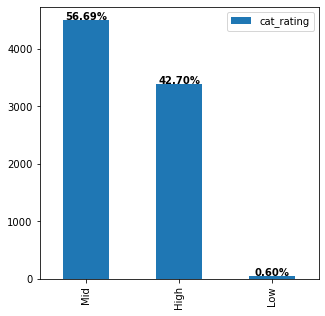

In [105]:
# Chart for average rating by category 

value_counts = df['cat_rating'].value_counts()
ax = value_counts.plot(kind='bar', figsize=(5, 5))

# Add percentage labels to each bar
for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x() + i.get_width() / 2., height + 0.5, f'{height/len(df)*100:.2f}%', ha='center', fontweight='bold')

ax.legend()

plt.show()


Action  remodelisation to rebalance (smot)

In [106]:
df["cat_rating"] = df['cat_rating'].replace({'High': 3, 'Mid': 2, "Low": 1 })
df

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher,number_of_authors,primary_author,type,cat_rating
bookID,,,,,,,,,,,,,,,,
4,NaN,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,2003-11-01,11,2003,Scholastic,single,J.K. Rowling,readable,3
9,NaN,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,eng,152,19,1,2005-04-26,4,2005,Nimble Books,single,W. Frederick Zimmerman,readable,2
16,NaN,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams/Stephen Fry,4.22,eng,6,1266,253,2005-03-23,3,2005,Random House Audio,multiple,Douglas Adams,audible,3
23,NaN,Bryson's Dictionary of Troublesome Words: A Wr...,Bill Bryson,3.87,eng,256,2088,131,2004-09-14,9,2004,Broadway Books,single,Bill Bryson,readable,2
37,NaN,The Lord of the Rings: Complete Visual Companion,Jude Fisher,4.50,eng,224,359,6,2004-11-15,11,2004,Houghton Mifflin Harcourt,single,Jude Fisher,readable,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45631,NaN,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,eng,512,156,20,2004-12-21,12,2004,Da Capo Press,multiple,William T. Vollmann,readable,3
45633,NaN,You Bright and Risen Angels,William T. Vollmann,4.08,eng,635,783,56,1988-12-01,12,1988,Penguin Books,single,William T. Vollmann,readable,3
45634,NaN,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,eng,415,820,95,1993-08-01,8,1993,Penguin Books,single,William T. Vollmann,readable,2


In [107]:
avg_count = df.groupby(["cat_rating"]).mean().ratings_count.to_dict()
avg_count

{1: 167.22916666666666, 2: 935.2166297117517, 3: 1200.7683249926406}

In [108]:
def count_guesser(count):
    avg = avg_count[count]
    return avg

In [109]:
for i in avg_count.keys():
    temp_df = df.loc[(df.cat_rating == i),:]
    missing_values_index = temp_df.loc[temp_df.ratings_count ==0].index
    df.loc[missing_values_index,"ratings_count"] =count_guesser(i)

## Data Processing 

In [110]:
labelencoder = LabelEncoder()
df['language_cat'] = labelencoder.fit_transform(df['language_code'])
df

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher,number_of_authors,primary_author,type,cat_rating,language_cat
bookID,,,,,,,,,,,,,,,,,
4,NaN,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333.0,244,2003-11-01,11,2003,Scholastic,single,J.K. Rowling,readable,3,2
9,NaN,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,eng,152,19.0,1,2005-04-26,4,2005,Nimble Books,single,W. Frederick Zimmerman,readable,2,2
16,NaN,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams/Stephen Fry,4.22,eng,6,1266.0,253,2005-03-23,3,2005,Random House Audio,multiple,Douglas Adams,audible,3,2
23,NaN,Bryson's Dictionary of Troublesome Words: A Wr...,Bill Bryson,3.87,eng,256,2088.0,131,2004-09-14,9,2004,Broadway Books,single,Bill Bryson,readable,2,2
37,NaN,The Lord of the Rings: Complete Visual Companion,Jude Fisher,4.50,eng,224,359.0,6,2004-11-15,11,2004,Houghton Mifflin Harcourt,single,Jude Fisher,readable,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45631,NaN,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,eng,512,156.0,20,2004-12-21,12,2004,Da Capo Press,multiple,William T. Vollmann,readable,3,2
45633,NaN,You Bright and Risen Angels,William T. Vollmann,4.08,eng,635,783.0,56,1988-12-01,12,1988,Penguin Books,single,William T. Vollmann,readable,3,2
45634,NaN,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,eng,415,820.0,95,1993-08-01,8,1993,Penguin Books,single,William T. Vollmann,readable,2,2


In [111]:
df["co-author"] = df['number_of_authors'].replace({'single': 0, 'multiple': 1})

In [112]:
df['author_cat'] = labelencoder.fit_transform(df['primary_author'])
df

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,month,year,publisher,number_of_authors,primary_author,type,cat_rating,language_cat,co-author,author_cat
bookID,,,,,,,,,,,,,,,,,,,
4,NaN,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333.0,244,2003-11-01,11,2003,Scholastic,single,J.K. Rowling,readable,3,2,0,1388
9,NaN,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,eng,152,19.0,1,2005-04-26,4,2005,Nimble Books,single,W. Frederick Zimmerman,readable,2,2,0,3513
16,NaN,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams/Stephen Fry,4.22,eng,6,1266.0,253,2005-03-23,3,2005,Random House Audio,multiple,Douglas Adams,audible,3,2,1,844
23,NaN,Bryson's Dictionary of Troublesome Words: A Wr...,Bill Bryson,3.87,eng,256,2088.0,131,2004-09-14,9,2004,Broadway Books,single,Bill Bryson,readable,2,2,0,327
37,NaN,The Lord of the Rings: Complete Visual Companion,Jude Fisher,4.50,eng,224,359.0,6,2004-11-15,11,2004,Houghton Mifflin Harcourt,single,Jude Fisher,readable,3,2,0,1807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45631,NaN,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,eng,512,156.0,20,2004-12-21,12,2004,Da Capo Press,multiple,William T. Vollmann,readable,3,2,1,3605
45633,NaN,You Bright and Risen Angels,William T. Vollmann,4.08,eng,635,783.0,56,1988-12-01,12,1988,Penguin Books,single,William T. Vollmann,readable,3,2,0,3605
45634,NaN,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,eng,415,820.0,95,1993-08-01,8,1993,Penguin Books,single,William T. Vollmann,readable,2,2,0,3605


In [115]:
df.value_counts().head(50)


ValueError: 'bookID' is both an index level and a column label, which is ambiguous.

In [116]:
new_df = df[["average_rating","num_pages","ratings_count","text_reviews_count","month","year"]]

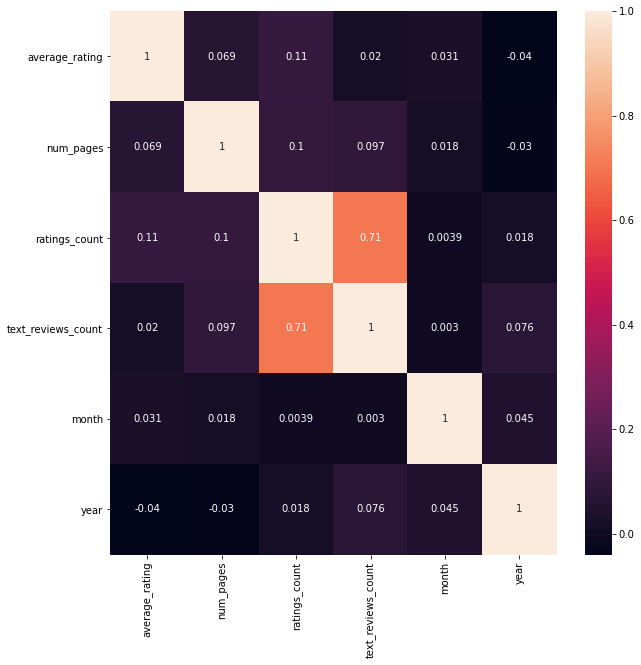

In [118]:
plt.figure(figsize=(10,10))
sns.heatmap(new_df.corr(),annot=True)
plt.show()

# Modeling

# Next Steps

1. In the correlation section
   * Corr month publication // avg rating / rating counts / text review
   (does it make sense?? are the people buying the book it is being published and rating right away, and writting a review?)
   * Corr year publication // avg rating / rating counts / text review
   
   
   
 I guess we've done enough vizualisation, exploratory, cleaning ... 
    lets start preparing the data for the ML model 
    
    
2. Transforming categorical columns into numerical columns 
  (using label encoding)
    * Title
    * Authors 
    * Language 
    * Publisher